Xgboost Algorithm

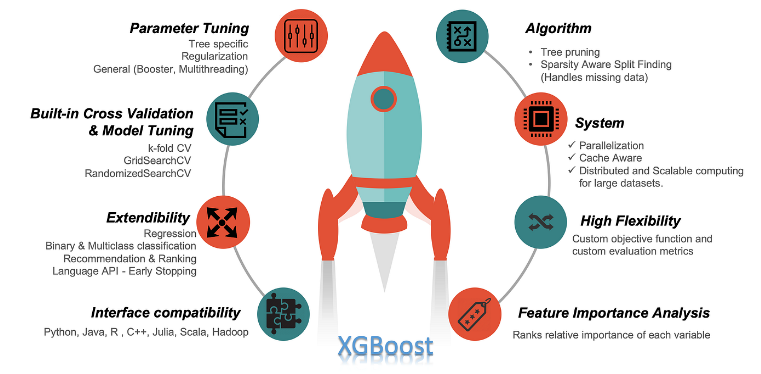

In [46]:
%pip install xgboost


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
from warnings import filterwarnings 
filterwarnings('ignore')

Step 1: Read the train dataset

In [48]:
import pandas as pd
df=pd.read_csv("train_weather.csv")
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


Step 2: Perform basic data quality checks

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


In [50]:
df.dtypes

Temperature             float64
Humidity                  int64
Wind Speed              float64
Precipitation (%)       float64
Cloud Cover              object
Atmospheric Pressure    float64
UV Index                  int64
Season                   object
Visibility (km)         float64
Location                 object
Weather Type             object
dtype: object

In [51]:
df.isna().sum()

Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64

In [52]:
df.duplicated().sum()

0

In [53]:
# Remove the duplicates
df = df.drop_duplicates(keep="first")

Step 3 - Seperating X and Y

In [54]:
X=df.drop(columns=['Weather Type'])
Y=df[['Weather Type']]

In [55]:
X.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain


In [56]:
Y.head()

,Weather Type
0,Rainy
1,Cloudy
2,Sunny
3,Sunny
4,Rainy


In [57]:
Y.value_counts()

Weather Type
Cloudy          3300
Rainy           3300
Snowy           3300
Sunny           3300
Name: count, dtype: int64

Preprocess X and Y

Applicable to only xgboost - Also need to label encode Y variable

In [58]:
con = list(X.columns[X.dtypes=="obect"])
cat = list(X.columns[X.dtypes!="object"])

In [59]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer 

In [60]:
num_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

In [61]:
cat_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', sparse_output=False)
)

In [62]:
pre = ColumnTransformer(
    [
        ('num', num_pipe, con),
        ('cat', cat_pipe, cat)
    ]
).set_output(transform='pandas')

In [63]:
X_pre = pre.fit_transform(X)
X_pre.head()

,cat__Temperature_-25.0,cat__Temperature_-24.0,cat__Temperature_-23.0,cat__Temperature_-22.0,cat__Temperature_-21.0,cat__Temperature_-20.0,cat__Temperature_-19.0,cat__Temperature_-18.0,cat__Temperature_-17.0,cat__Temperature_-16.0,...,cat__Visibility (km)_15.5,cat__Visibility (km)_16.0,cat__Visibility (km)_16.5,cat__Visibility (km)_17.0,cat__Visibility (km)_17.5,cat__Visibility (km)_18.0,cat__Visibility (km)_18.5,cat__Visibility (km)_19.0,cat__Visibility (km)_19.5,cat__Visibility (km)_20.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Label encode Y features

In [64]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y_pre = le.fit_transform(Y)

In [65]:
Y_pre[0:5]

array([1, 0, 3, 3, 1])

Step 4 : Train test split

In [66]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_pre, Y_pre, test_size=0.2, random_state=42)

In [67]:
xtrain.head()

,cat__Temperature_-25.0,cat__Temperature_-24.0,cat__Temperature_-23.0,cat__Temperature_-22.0,cat__Temperature_-21.0,cat__Temperature_-20.0,cat__Temperature_-19.0,cat__Temperature_-18.0,cat__Temperature_-17.0,cat__Temperature_-16.0,...,cat__Visibility (km)_15.5,cat__Visibility (km)_16.0,cat__Visibility (km)_16.5,cat__Visibility (km)_17.0,cat__Visibility (km)_17.5,cat__Visibility (km)_18.0,cat__Visibility (km)_18.5,cat__Visibility (km)_19.0,cat__Visibility (km)_19.5,cat__Visibility (km)_20.0
3958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
ytrain[0:5]

array([1, 1, 3, 1, 0])

In [69]:
xtest.head()

,cat__Temperature_-25.0,cat__Temperature_-24.0,cat__Temperature_-23.0,cat__Temperature_-22.0,cat__Temperature_-21.0,cat__Temperature_-20.0,cat__Temperature_-19.0,cat__Temperature_-18.0,cat__Temperature_-17.0,cat__Temperature_-16.0,...,cat__Visibility (km)_15.5,cat__Visibility (km)_16.0,cat__Visibility (km)_16.5,cat__Visibility (km)_17.0,cat__Visibility (km)_17.5,cat__Visibility (km)_18.0,cat__Visibility (km)_18.5,cat__Visibility (km)_19.0,cat__Visibility (km)_19.5,cat__Visibility (km)_20.0
4111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
ytest[0:5]

array([3, 3, 3, 2, 3])

In [71]:
xtrain.shape

(10560, 5935)

In [72]:
xtest.shape

(2640, 5935)

Build the model

In [73]:
from xgboost import XGBClassifier
model = XGBClassifier(
    n_estimators = 300,
    max_depth = 3
)
model.fit(xtrain, ytrain, eval_set = [(xtest, ytest)], verbose=True)

[0]	validation_0-mlogloss:1.25891
[1]	validation_0-mlogloss:1.17031
[2]	validation_0-mlogloss:1.11159
[3]	validation_0-mlogloss:1.06643
[4]	validation_0-mlogloss:1.03115
[5]	validation_0-mlogloss:0.99854
[6]	validation_0-mlogloss:0.96775
[7]	validation_0-mlogloss:0.94119
[8]	validation_0-mlogloss:0.91294
[9]	validation_0-mlogloss:0.89250
[10]	validation_0-mlogloss:0.87235
[11]	validation_0-mlogloss:0.85246
[12]	validation_0-mlogloss:0.83642
[13]	validation_0-mlogloss:0.81706
[14]	validation_0-mlogloss:0.80280
[15]	validation_0-mlogloss:0.78751
[16]	validation_0-mlogloss:0.77420
[17]	validation_0-mlogloss:0.76153
[18]	validation_0-mlogloss:0.74772
[19]	validation_0-mlogloss:0.73706
[20]	validation_0-mlogloss:0.72595
[21]	validation_0-mlogloss:0.71605
[22]	validation_0-mlogloss:0.70695
[23]	validation_0-mlogloss:0.69623
[24]	validation_0-mlogloss:0.68735
[25]	validation_0-mlogloss:0.67996
[26]	validation_0-mlogloss:0.67063
[27]	validation_0-mlogloss:0.66238
[28]	validation_0-mlogloss:0.6

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [74]:
model.evals_result()

{'validation_0': OrderedDict([('mlogloss',
               [1.2589115139209863,
                1.1703138253002456,
                1.1115863984507142,
                1.0664279805891441,
                1.0311474592848258,
                0.9985413373419733,
                0.9677458840902105,
                0.9411938424476168,
                0.9129439006474885,
                0.8924975457742359,
                0.8723490470963897,
                0.8524617858343955,
                0.8364186604591933,
                0.8170605584979057,
                0.8028017828748985,
                0.7875069762946981,
                0.7741955681845094,
                0.7615341031077233,
                0.747719091419695,
                0.7370648476210507,
                0.7259503453066855,
                0.7160515075380152,
                0.706950671355607,
                0.6962325819965565,
                0.6873465655766653,
                0.6799616833979433,
                0.67063

In [75]:
loss = model.evals_result()['validation_0']['mlogloss']
loss

[1.2589115139209863,
 1.1703138253002456,
 1.1115863984507142,
 1.0664279805891441,
 1.0311474592848258,
 0.9985413373419733,
 0.9677458840902105,
 0.9411938424476168,
 0.9129439006474885,
 0.8924975457742359,
 0.8723490470963897,
 0.8524617858343955,
 0.8364186604591933,
 0.8170605584979057,
 0.8028017828748985,
 0.7875069762946981,
 0.7741955681845094,
 0.7615341031077233,
 0.747719091419695,
 0.7370648476210507,
 0.7259503453066855,
 0.7160515075380152,
 0.706950671355607,
 0.6962325819965565,
 0.6873465655766653,
 0.6799616833979433,
 0.6706339642292622,
 0.662384805263895,
 0.6566308394356659,
 0.6490533317975474,
 0.6415236709470099,
 0.6331937122186928,
 0.6267364421012727,
 0.6208972720034195,
 0.6144261870081678,
 0.609329486107736,
 0.6042403444337349,
 0.5993673602401307,
 0.5933423451260861,
 0.588747813239355,
 0.584394700715149,
 0.5795527830861057,
 0.5748802168210122,
 0.5695862612376611,
 0.5663352081411038,
 0.5618730936904974,
 0.5578072391901956,
 0.5542943431798256

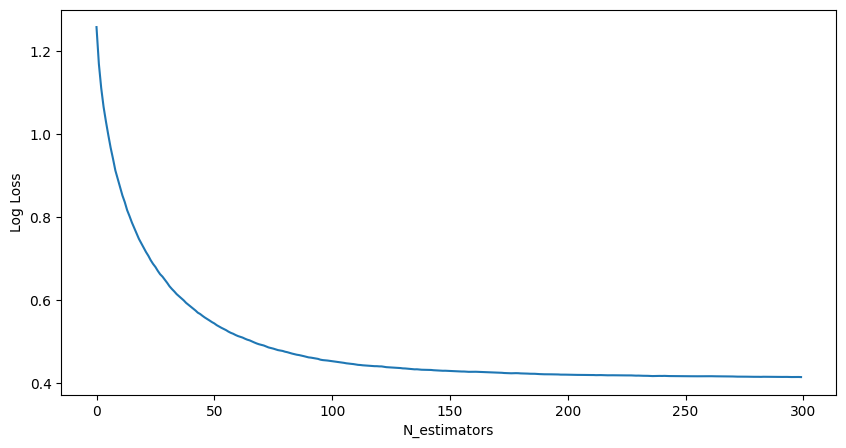

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(loss)
plt.xlabel("N_estimators")
plt.ylabel("Log Loss")
plt.show()

In [77]:
model.score(xtrain, ytrain)

0.9081439393939394

In [78]:
model.score(xtest, ytest)

0.8693181818181818

Always check cross validated F1 Macro Score

In [79]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, xtrain, ytrain, cv=5, scoring='f1_macro')
scores

array([0.86876218, 0.86308194, 0.87151637, 0.87537997, 0.87985083])

In [80]:
scores.mean()

0.8717182566978693

Feature importance

In [81]:
model.feature_importances_

array([0.        , 0.001558  , 0.        , ..., 0.00093827, 0.00100896,
       0.00074881], dtype=float32)

In [82]:
xtrain.columns

Index(['cat__Temperature_-25.0', 'cat__Temperature_-24.0',
       'cat__Temperature_-23.0', 'cat__Temperature_-22.0',
       'cat__Temperature_-21.0', 'cat__Temperature_-20.0',
       'cat__Temperature_-19.0', 'cat__Temperature_-18.0',
       'cat__Temperature_-17.0', 'cat__Temperature_-16.0',
       ...
       'cat__Visibility (km)_15.5', 'cat__Visibility (km)_16.0',
       'cat__Visibility (km)_16.5', 'cat__Visibility (km)_17.0',
       'cat__Visibility (km)_17.5', 'cat__Visibility (km)_18.0',
       'cat__Visibility (km)_18.5', 'cat__Visibility (km)_19.0',
       'cat__Visibility (km)_19.5', 'cat__Visibility (km)_20.0'],
      dtype='object', length=5935)

In [83]:
imp = pd.Series(
    model.feature_importances_,
    index = xtrain.columns
)
imp

cat__Temperature_-25.0       0.000000
cat__Temperature_-24.0       0.001558
cat__Temperature_-23.0       0.000000
cat__Temperature_-22.0       0.001524
cat__Temperature_-21.0       0.001441
                               ...   
cat__Visibility (km)_18.0    0.001404
cat__Visibility (km)_18.5    0.000000
cat__Visibility (km)_19.0    0.000938
cat__Visibility (km)_19.5    0.001009
cat__Visibility (km)_20.0    0.000749
Length: 5935, dtype: float32

In [84]:
imp.sort_values(ascending=False)

cat__UV Index_0.0                    0.022718
cat__UV Index_2.0                    0.017930
cat__UV Index_1.0                    0.017326
cat__UV Index_3.0                    0.017186
cat__Temperature_2.0                 0.015684
                                       ...   
cat__Atmospheric Pressure_994.97     0.000000
cat__Atmospheric Pressure_994.95     0.000000
cat__Atmospheric Pressure_994.93     0.000000
cat__Atmospheric Pressure_994.92     0.000000
cat__Atmospheric Pressure_1003.27    0.000000
Length: 5935, dtype: float32

In [85]:
imp.sort_values(ascending=False).sum()

1.0000001

<Axes: >

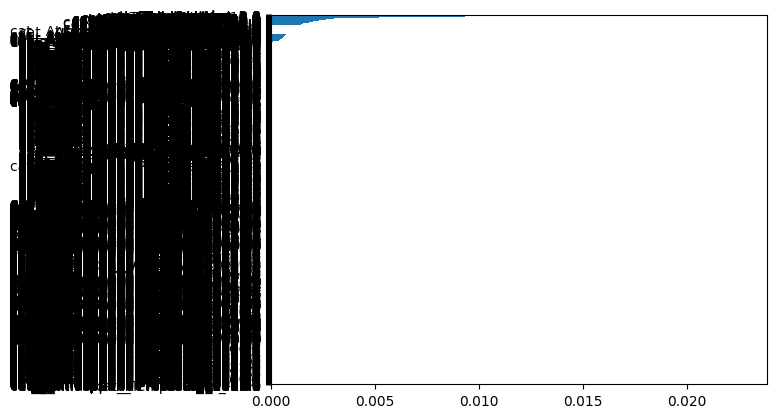

In [86]:
imp.sort_values().plot(kind='barh')

Step 6 : Model Evaluation

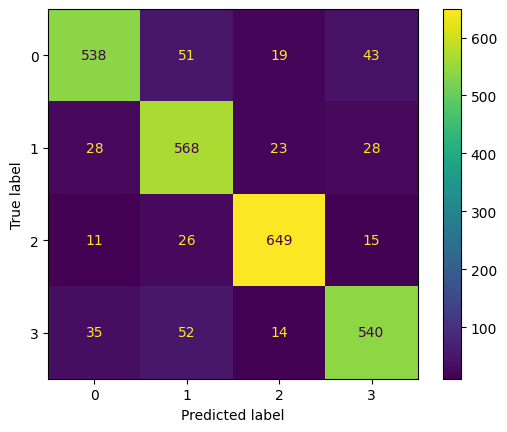

In [87]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, xtest, ytest)

In [88]:
ypred_train = model.predict(xtrain)
ypred_test = model.predict(xtest)

In [89]:

ytrain[0:5]

array([1, 1, 3, 1, 0])

In [90]:
ypred_train[0:5]

array([1, 1, 3, 1, 0], dtype=int64)

In [91]:
ytest[0:5]

array([3, 3, 3, 2, 3])

In [92]:

ypred_test[0:5]

array([3, 1, 3, 2, 3], dtype=int64)

In [93]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred_test))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85       651
           1       0.81      0.88      0.85       647
           2       0.92      0.93      0.92       701
           3       0.86      0.84      0.85       641

    accuracy                           0.87      2640
   macro avg       0.87      0.87      0.87      2640
weighted avg       0.87      0.87      0.87      2640



Because model has f1_macro = 0.91 > 0.8 hence model is very good

Step 7: Out of Sample Prediction

In [94]:
xnew = pd.read_csv('test_weather.csv')
xnew.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
0,0,68,16.0,66.0,overcast,984.94,0,Winter,2.0,mountain
1,107,107,15.0,83.0,partly cloudy,1015.00,11,Summer,7.0,mountain
2,19,76,12.5,35.0,partly cloudy,1017.26,4,Summer,8.0,inland
3,22,99,18.5,NaN,partly cloudy,1012.70,0,NaN,3.5,inland
4,33,25,8.0,6.0,partly cloudy,1023.77,6,Spring,NaN,inland


In [95]:
pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 []),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Temperature', 'Humidity', 'Wind Speed',
                                  'Precipitation (%)', 'Atmospheric Pressure',
                                  'UV Index', 'Visibility (km)'])])

In [96]:
xnew_pre = pre.transform(xnew)
xnew_pre.head()

,cat__Temperature_-25.0,cat__Temperature_-24.0,cat__Temperature_-23.0,cat__Temperature_-22.0,cat__Temperature_-21.0,cat__Temperature_-20.0,cat__Temperature_-19.0,cat__Temperature_-18.0,cat__Temperature_-17.0,cat__Temperature_-16.0,...,cat__Visibility (km)_15.5,cat__Visibility (km)_16.0,cat__Visibility (km)_16.5,cat__Visibility (km)_17.0,cat__Visibility (km)_17.5,cat__Visibility (km)_18.0,cat__Visibility (km)_18.5,cat__Visibility (km)_19.0,cat__Visibility (km)_19.5,cat__Visibility (km)_20.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
ypred = model.predict(xnew_pre)
yprob = model.predict_proba(xnew_pre)

In [98]:
ypred[0:5]

array([2, 3, 0, 1, 3], dtype=int64)

In [99]:
le

LabelEncoder()

In [100]:
ypred_lb = le.inverse_transform(ypred)
ypred_lb[0:5]

array(['Snowy', 'Sunny', 'Cloudy', 'Rainy', 'Sunny'], dtype=object)

In [101]:
model.classes_

array([0, 1, 2, 3])

In [102]:
import numpy as np 
max_probs = np.max(yprob, axis=1)
max_probs[0:5]

array([0.97021097, 0.62850314, 0.9653409 , 0.60383755, 0.810818  ],
      dtype=float32)

Save above results in csv

In [103]:
xnew['Weather Type'] = ypred_lb
xnew['Probability'] = max_probs

In [104]:
xnew

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type,Probability
0,0,68,16.0,66.0,overcast,984.94,0,Winter,2.0,mountain,Snowy,0.970211
1,107,107,15.0,83.0,partly cloudy,1015.00,11,Summer,7.0,mountain,Sunny,0.628503
2,19,76,12.5,35.0,partly cloudy,1017.26,4,Summer,8.0,inland,Cloudy,0.965341
3,22,99,18.5,NaN,partly cloudy,1012.70,0,NaN,3.5,inland,Rainy,0.603838
4,33,25,8.0,6.0,partly cloudy,1023.77,6,Spring,NaN,inland,Sunny,0.810818
...,...,...,...,...,...,...,...,...,...,...,...,...
95,27,59,9.5,41.0,overcast,1001.39,4,Spring,8.0,mountain,Cloudy,0.962833
96,73,82,47.0,107.0,overcast,1002.73,0,Winter,0.5,mountain,Rainy,0.752793
97,2,60,3.0,70.0,overcast,994.19,0,Winter,2.0,mountain,Snowy,0.977107
98,33,44,1.5,11.0,clear,1011.95,7,Summer,8.5,inland,Sunny,0.898993


In [105]:
xnew.to_csv("XGBResults.csv", index=False)